In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
import scanpy as sc

from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scvi
import pandas as pd

import matplotlib.pyplot as plt



Global seed set to 0


In [2]:
adata_multi = sc.read_10x_mtx('./data/datasets/NEAT_Seq/outputs/RNA_ATAC/',gex_only=False)
metadata = pd.read_csv('./data/datasets/NEAT_Seq/metadata.csv',index_col = 0)
adata_multi.obs = pd.merge(adata_multi.obs, metadata, left_index=True, right_index=True)

In [3]:
adata_multi

AnnData object with n_obs × n_vars = 3841 × 117554
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_id', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'cell_id2', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_ChromVar', 'nFeature_ChromVar', 'RNA_snn_res.0.6', 'seurat_clusters', 'nCount_ADT', 'nFeature_ADT', 'FOXP3-norm', 'Helios-norm', 'Tbet-norm', 'GATA3-norm', 'RORgT-norm'
    var: 'gene_ids', 'feature_types'

In [4]:
sc.pp.filter_genes(adata_multi, min_cells=10)

In [5]:
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_multi.var["modality"].value_counts()
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
adata_mvi 


AnnData object with n_obs × n_vars = 3841 × 92370
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_id', 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'cell_id2', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_ChromVar', 'nFeature_ChromVar', 'RNA_snn_res.0.6', 'seurat_clusters', 'nCount_ADT', 'nFeature_ADT', 'FOXP3-norm', 'Helios-norm', 'Tbet-norm', 'GATA3-norm', 'RORgT-norm', 'batch_id', 'modality'
    var: 'gene_ids', 'feature_types', 'n_cells', 'modality'

In [6]:
adata_mvi.obs['Clusters'] = adata_mvi.obs['Clusters'].astype(str).astype('category')
old_to_new = dict(
    C1='Act.',
    C2='Treg',
    C3='Th17',
    C4='Tcm',
    C5='Th2',
    C6='Th1',
    C7='Uncom.'
)
adata_mvi.obs['new_clusters'] = (
    adata_mvi.obs['Clusters']
    .map(old_to_new)
    .astype('category')
)

Cluster_color = {
                "Act.": "#D51F26",
                "Treg": "#272E6A",
                "Th17": "#208A42",
                "Tcm": "#89288F",
                "Th2": "#F47D2B",
                "Th1": "#FEE500",
                "Uncom.": "#8A9FD1"    
                }

adata_mvi.obs['GATA3-norm'] = (adata_mvi.obs['GATA3-norm'] - adata_mvi.obs['GATA3-norm'].min()) / (adata_mvi.obs['GATA3-norm'].max() - adata_mvi.obs['GATA3-norm'].min())

adata_mvi.obs['new_clusters'].value_counts()

Tcm       1152
Th17       851
Th1        685
Th2        436
Uncom.     421
Treg       249
Act.        47
Name: new_clusters, dtype: int64

# HALO Training

In [7]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='GATA3-norm')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['feature_types']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['feature_types']=='Peaks').sum(),
    n_layers = 2,
    n_latent = 30,
    n_dependent=15
)

n_genes :13799
n_peaks:78571
fine tune is False
gate decoder initialization n_input 30, n_output 78571,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [8]:
## train both RNA and ATAC
import warnings
warnings.filterwarnings("ignore")
model.module.set_finetune_params(0)
model.module.set_train_params(expr_train=True, acc_train=True)
model.train(max_epochs=1000, batch_size=256)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|██████████| 1000/1000 [46:36<00:00,  2.80s/it, loss=5.42e+04, v_num=1]


In [9]:
model.save("model_NEAT_seq_30LF_nocausal_epoch1000",overwrite=True)

In [10]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

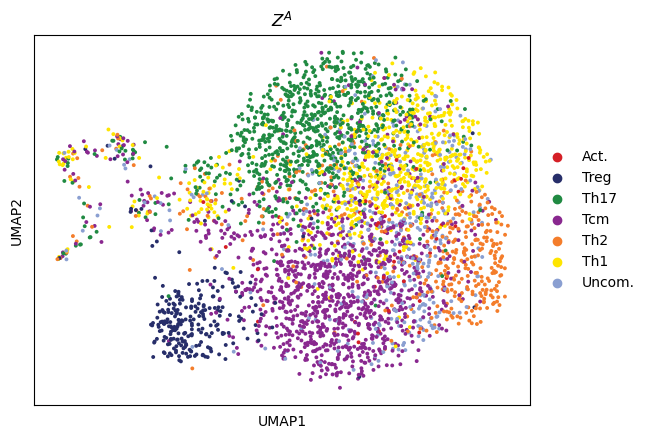

In [13]:
adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

# %matplotlib inline
# sc.pl.umap(adatssa_mvi,color='GATA3-norm',title = '$Z^{A}$',
#        vmin = 'p2', vmax= 'p98')
# plt.show()

%matplotlib inline
sc.pl.umap(adata_mvi,color='new_clusters',title = '$Z^{A}$',
                palette=Cluster_color
             )
plt.show()

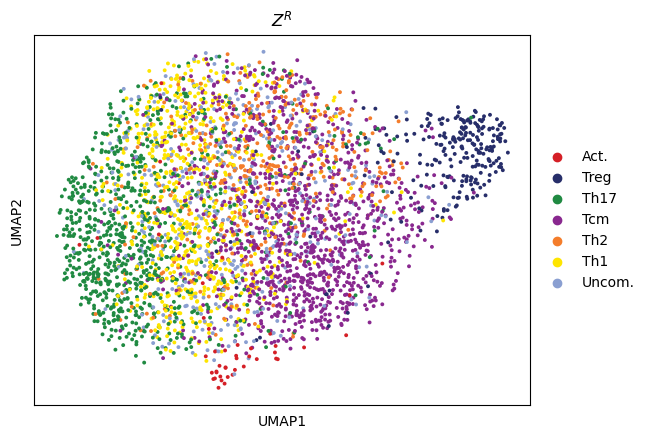

In [14]:
adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)

# %matplotlib inline
# sc.pl.umap(adata_mvi,color='GATA3-norm',title = '$Z^{R}$',
#        vmin = 'p2', vmax= 'p98')
# plt.show()

%matplotlib inline
sc.pl.umap(adata_mvi,color='new_clusters',title = '$Z^{R}$',
                palette=Cluster_color
             )
plt.show()

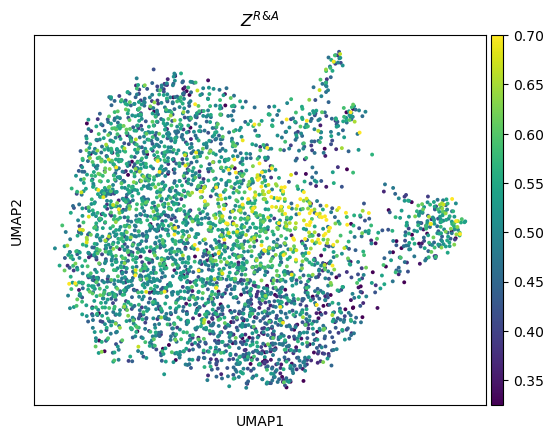

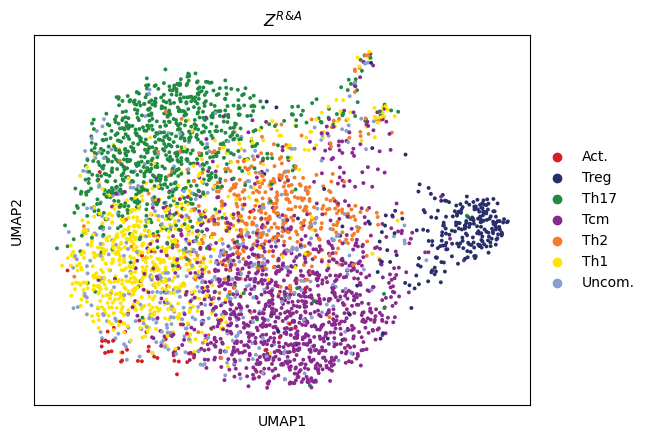

In [15]:
adata_mvi.obsm["latent"] = np.concatenate((latent_expr, latent_acc), axis=1)
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)

%matplotlib inline
sc.pl.umap(adata_mvi,color='GATA3-norm',title = '$Z^{R & A}$',
       vmin = 'p2', vmax= 'p98')
plt.show()

%matplotlib inline
sc.pl.umap(adata_mvi,color='new_clusters',title = '$Z^{R & A}$',
                palette=Cluster_color
             )
plt.show()

In [16]:
model.train(max_epochs=1000, batch_size=256)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1000/1000: 100%|██████████| 1000/1000 [45:47<00:00,  2.75s/it, loss=5.4e+04, v_num=1] 


In [17]:
model.save("model_NEAT_seq_30LF_nocausal_epoch_2000",overwrite=True)

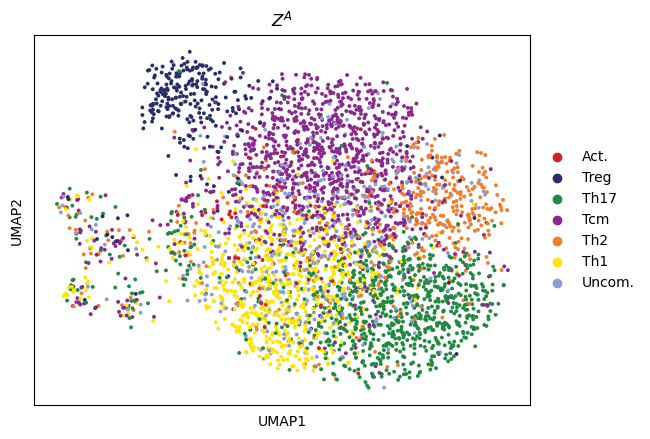

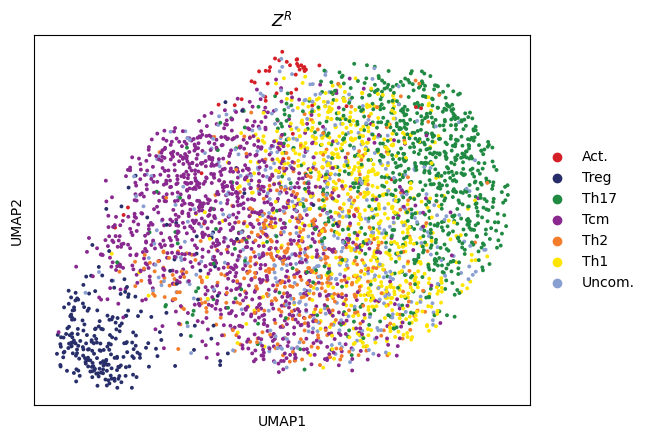

In [20]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)

%matplotlib inline
sc.pl.umap(adata_mvi,color='new_clusters',title = '$Z^{A}$',
                palette=Cluster_color
             )
plt.show()


adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)

%matplotlib inline
sc.pl.umap(adata_mvi,color='new_clusters',title = '$Z^{R}$',
                palette=Cluster_color
             )
plt.show()

# Causal Constrain

In [9]:
model = model.load("model_NEAT_seq_30LF_nocausal_epoch1000",adata_mvi)

INFO     File model_NEAT_seq_30LF_nocausal_epoch1000/model.pt already downloaded             
n_genes :13799
n_peaks:78571
fine tune is False
gate decoder initialization n_input 30, n_output 78571,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


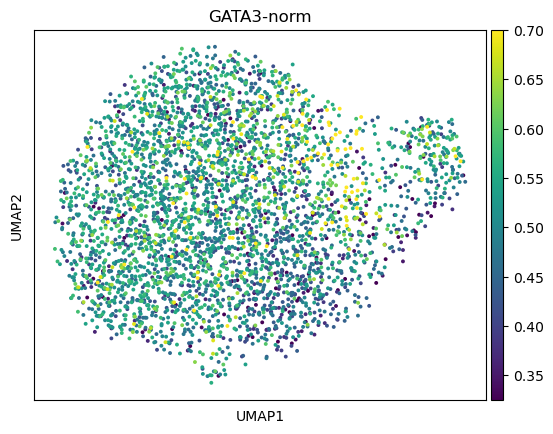

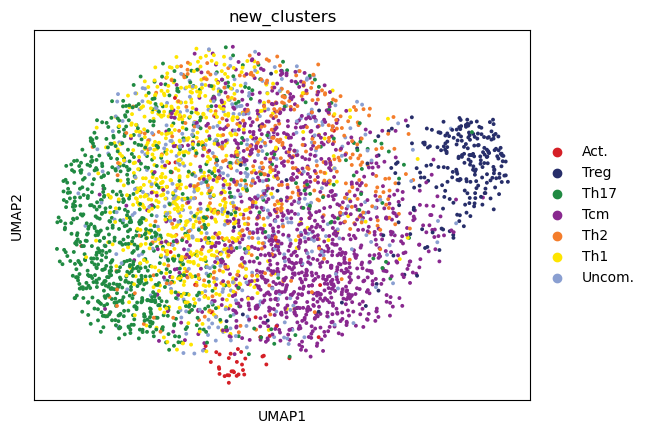

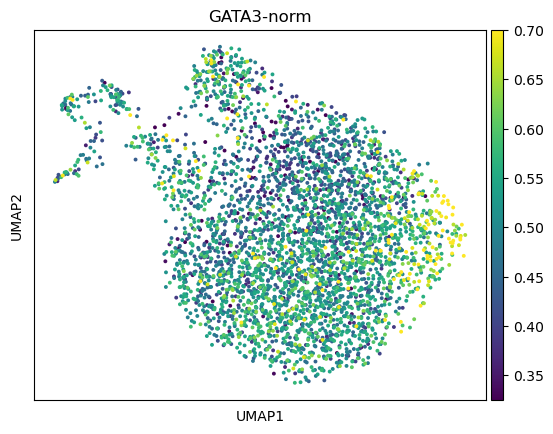

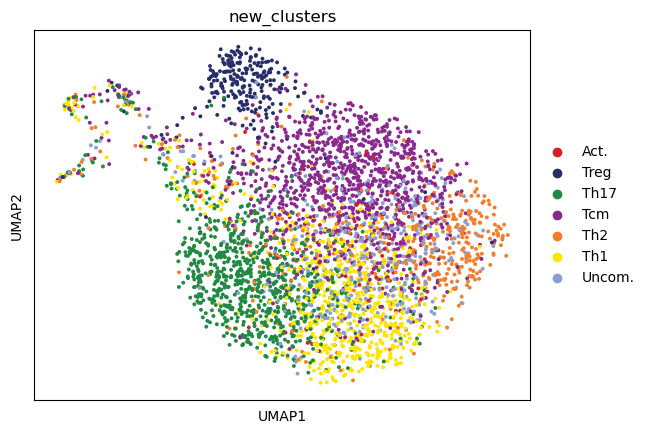

In [10]:
latent_expr, latent_acc,latent_atac_dep, latent_expr_dep, latent_atac_indep, latent_expr_indep, times  = model.get_latent_representation()

adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)

%matplotlib inline
sc.pl.umap(adata_mvi,color='GATA3-norm', vmin = 'p2', vmax= 'p98')
plt.show()

%matplotlib inline
sc.pl.umap(adata_mvi,color='new_clusters',palette=Cluster_color)
plt.show()

adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)

%matplotlib inline
sc.pl.umap(adata_mvi,color='GATA3-norm', vmin = 'p2', vmax= 'p98')
plt.show()

%matplotlib inline
sc.pl.umap(adata_mvi,color='new_clusters',palette=Cluster_color)
plt.show()

In [11]:
model.module.alpha = 0.05
model.module.beta_2 = 1e7
model.module.beta_3 = 2e8
model.module.beta_1 = 1e7
print(model.module.alpha)

0.05


In [12]:
## finetune without L0
model.module.set_finetune_params(2)
model.module.set_train_params(expr_train=True, acc_train=True)
model.plan_kwargs = {"n_epochs_kl_warmup":300}
model.train(max_epochs=500, batch_size=512)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]reconst_loss 5.46E+04, nod_loss 2.92E+05
reconst_loss 5.30E+04, nod_loss 3.31E+05
reconst_loss 5.42E+04, nod_loss 2.92E+05
reconst_loss 5.45E+04, nod_loss 3.64E+05
reconst_loss 5.37E+04, nod_loss 2.57E+05
reconst_loss 5.40E+04, nod_loss 3.12E+05
reconst_loss 5.33E+04, nod_loss 3.30E+05
Epoch 2/500:   0%|          | 1/500 [00:03<32:19,  3.89s/it, loss=3.65e+05, v_num=1]reconst_loss 5.35E+04, nod_loss 2.99E+05
reconst_loss 5.47E+04, nod_loss 2.87E+05
reconst_loss 5.45E+04, nod_loss 3.38E+05
reconst_loss 5.29E+04, nod_loss 3.18E+05
reconst_loss 5.37E+04, nod_loss 3.54E+05
reconst_loss 5.41E+04, nod_loss 2.75E+05
reconst_loss 5.43E+04, nod_loss 3.22E+05
Epoch 3/500:   0%|          | 2/500 [00:07<29:14,  3.52s/it, loss=3.66e+05, v_num=1]reconst_loss 5.42E+04, nod_loss 3.02E+05
reconst_loss 5.41E+04, nod_loss 2.99E+05
reconst_loss 5.40E+04, nod_loss 3.21E+05
reconst_loss 5.32E+04, nod_loss 2.96E+05
reconst_loss 5.42E+04, nod_loss 3.15E+05
r

In [13]:
model.save("model_NEAT_seq_30LF_causal_alpha_0.05_epoch_500",overwrite=True)

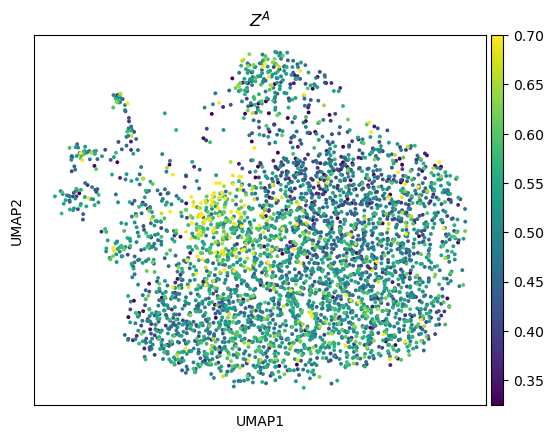

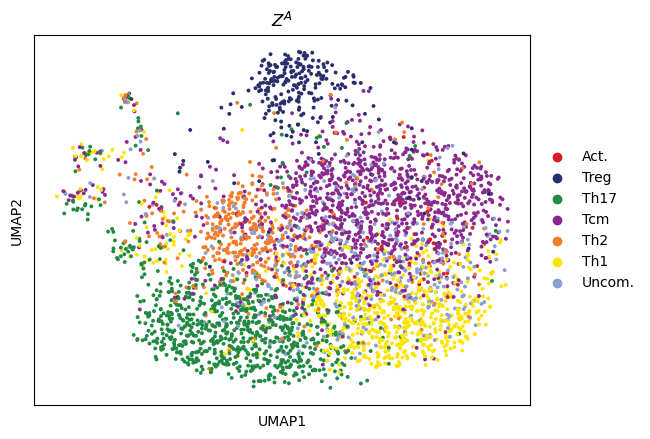

In [14]:
latent_expr, latent_acc,latent_atac_dep, latent_expr_dep, latent_atac_indep, latent_expr_indep, times  = model.get_latent_representation()

adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
sc.pl.umap(adata_mvi,color='GATA3-norm',title = '$Z^{A}$',
       vmin = 'p2', vmax= 'p98')
plt.show()

%matplotlib inline
sc.pl.umap(adata_mvi,color='new_clusters',title = '$Z^{A}$',
                palette=Cluster_color
             )
plt.show()

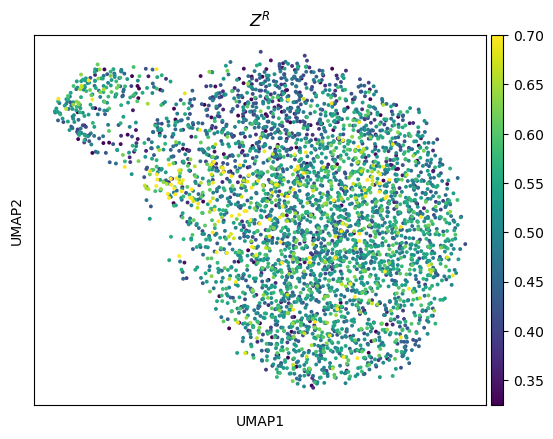

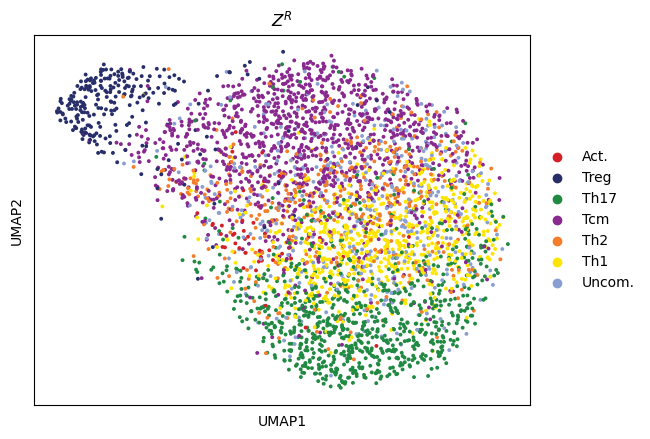

In [15]:
adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)

%matplotlib inline
sc.pl.umap(adata_mvi,color='GATA3-norm',title = '$Z^{R}$',
       vmin = 'p2', vmax= 'p98')
plt.show()

%matplotlib inline
sc.pl.umap(adata_mvi,color='new_clusters',title = '$Z^{R}$',
                palette=Cluster_color
             )
plt.show()

In [16]:
model.train(max_epochs=500, batch_size=512)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]reconst_loss 5.41E+04, nod_loss 2.69E+05
reconst_loss 5.45E+04, nod_loss 3.08E+05
reconst_loss 5.38E+04, nod_loss 3.06E+05
reconst_loss 5.39E+04, nod_loss 3.00E+05
reconst_loss 5.42E+04, nod_loss 2.92E+05
reconst_loss 5.35E+04, nod_loss 3.45E+05
reconst_loss 5.33E+04, nod_loss 3.99E+05
Epoch 2/500:   0%|          | 1/500 [00:02<24:40,  2.97s/it, loss=3.71e+05, v_num=1]reconst_loss 5.41E+04, nod_loss 3.43E+05
reconst_loss 5.40E+04, nod_loss 2.71E+05
reconst_loss 5.36E+04, nod_loss 3.42E+05
reconst_loss 5.43E+04, nod_loss 3.42E+05
reconst_loss 5.37E+04, nod_loss 2.89E+05
reconst_loss 5.35E+04, nod_loss 2.91E+05
reconst_loss 5.42E+04, nod_loss 2.77E+05
Epoch 3/500:   0%|          | 2/500 [00:05<24:53,  3.00s/it, loss=3.66e+05, v_num=1]reconst_loss 5.37E+04, nod_loss 3.14E+05
reconst_loss 5.48E+04, nod_loss 2.77E+05
reconst_loss 5.45E+04, nod_loss 2.60E+05
reconst_loss 5.34E+04, nod_loss 3.36E+05
reconst_loss 5.33E+04, nod_loss 3.08E+05
r

In [18]:
model.save("model_NEAT_seq_30LF_causal_alpha_0.05_epoch_1000",overwrite=True)

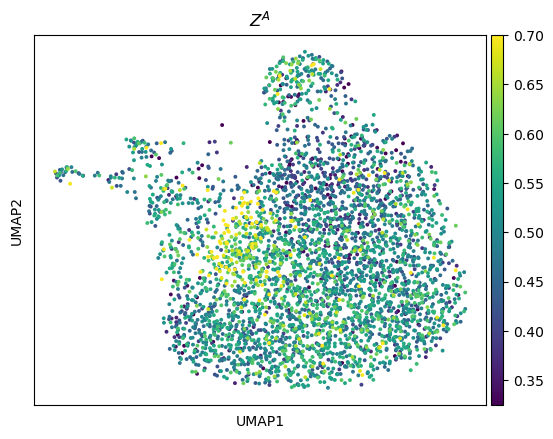

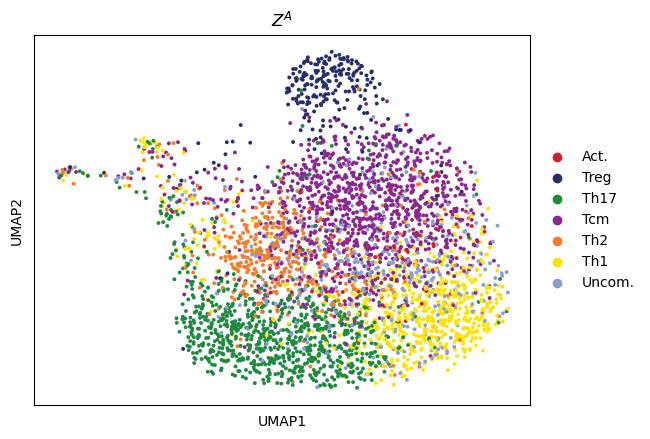

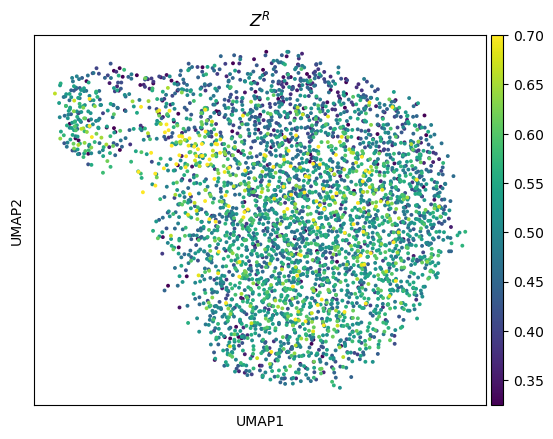

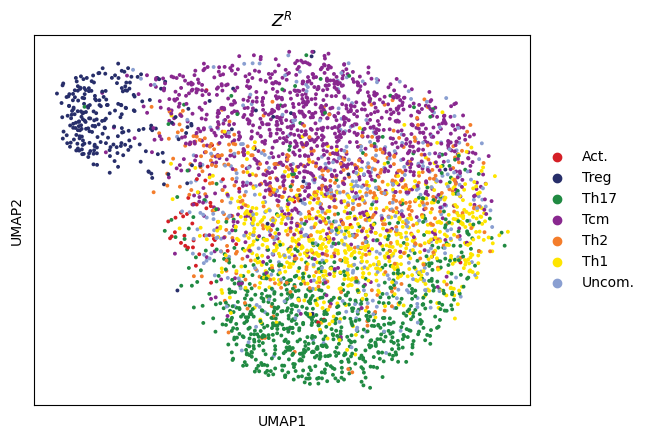

In [17]:
latent_expr, latent_acc,latent_atac_dep, latent_expr_dep, latent_atac_indep, latent_expr_indep, times  = model.get_latent_representation()

adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
sc.pl.umap(adata_mvi,color='GATA3-norm',title = '$Z^{A}$',
       vmin = 'p2', vmax= 'p98')
plt.show()

%matplotlib inline
sc.pl.umap(adata_mvi,color='new_clusters',title = '$Z^{A}$',
                palette=Cluster_color
             )
plt.show()


adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)

%matplotlib inline
sc.pl.umap(adata_mvi,color='GATA3-norm',title = '$Z^{R}$',
       vmin = 'p2', vmax= 'p98')
plt.show()

%matplotlib inline
sc.pl.umap(adata_mvi,color='new_clusters',title = '$Z^{R}$',
                palette=Cluster_color
             )
plt.show()

# visualize

In [10]:
model = model.load("model_NEAT_seq_30LF_causal_alpha_0.05_epoch_500",adata_mvi)

INFO     File model_NEAT_seq_30LF_causal_alpha_0.05_epoch_500/model.pt already downloaded    
n_genes :13799
n_peaks:78571
fine tune is False
gate decoder initialization n_input 30, n_output 78571,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


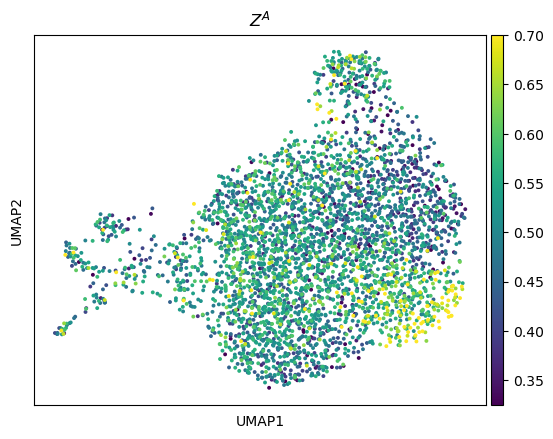

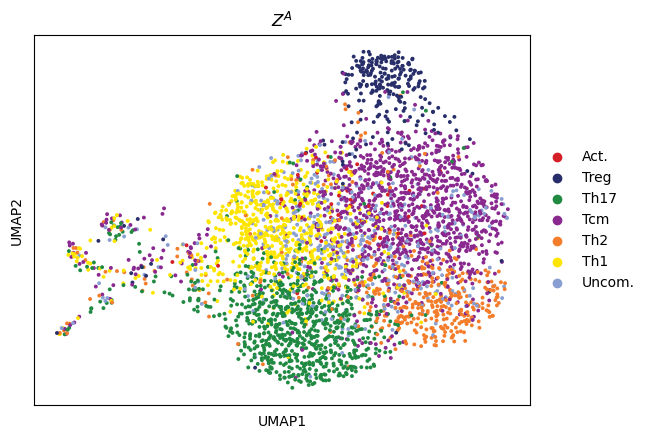

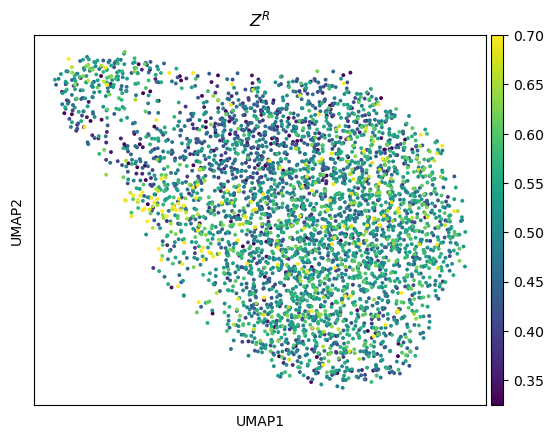

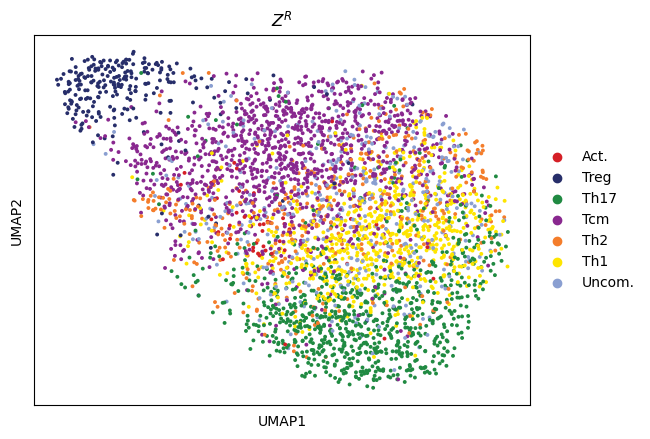

In [11]:
latent_expr, latent_acc,latent_atac_dep, latent_expr_dep, latent_atac_indep, latent_expr_indep, times  = model.get_latent_representation()

adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
sc.pl.umap(adata_mvi,color='GATA3-norm',title = '$Z^{A}$',
       vmin = 'p2', vmax= 'p98')
plt.show()

%matplotlib inline
sc.pl.umap(adata_mvi,color='new_clusters',title = '$Z^{A}$',
                palette=Cluster_color
             )
plt.show()


adata_mvi.obsm["latent"] = latent_expr
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)

%matplotlib inline
sc.pl.umap(adata_mvi,color='GATA3-norm',title = '$Z^{R}$',
       vmin = 'p2', vmax= 'p98')
plt.show()

%matplotlib inline
sc.pl.umap(adata_mvi,color='new_clusters',title = '$Z^{R}$',
                palette=Cluster_color
             )
plt.show()